In [35]:
%%time

# Data Manipulation
import pandas as pd
pd.set_option('use_inf_as_na', True)
import numpy as np
from sklearn.model_selection import train_test_split

# tweets processing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords

# Visual modules
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Converting words to numbers (bags of words)
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

# Pipeline processor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Algorithms
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier


# Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Save model
import joblib

Wall time: 38 ms


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bless\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bless\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [36]:
#CONSTANTS
TWITTER_LOGO = 'Twitter logo 2012.png'
EXTRA_WORDS = 'extra_words.txt'
TRAIN_FILE = 'train.csv'
SUB_FILE = 'test.csv'
FONT_PATH = r'gatsby\GatsbyFLF-bold.ttf'

MODEL_FILE = 'some-model'


In [37]:
#Load data and extract inputs and outputs
data_df = pd.read_csv(r'.\Data\train.csv').set_index('id')[:1000]

texts = data_df.drop(['target'], axis = 1)
#tweets = texts.text
y = data_df.target

In [38]:
texts.head()

,keyword,location,text
id,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...
4,NaN,NaN,Forest fire near La Ronge Sask. Canada
5,NaN,NaN,All residents asked to 'shelter in place' are ...
6,NaN,NaN,"13,000 people receive #wildfires evacuation or..."
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...


In [39]:
data_df.sample(frac=1).head()

,keyword,location,text,target
id,,,,
1078,bleeding,"Alicante, Valencia",they say bad things happen for a reason\nbut n...,0
85,ablaze,NaN,Revel in yours wmv videos by means of mac fare...,0
1351,blown%20up,Scotland,@KaylaK369 got it last month when I went into ...,0
1301,bloody,"Level 3 Garrison, Sector G",Bloody hell what a day. I haven't even really ...,0
1109,blew%20up,NaN,Catfish retweeted me &amp; my notifications bl...,0


In [40]:
full_text = texts.keyword.fillna(' ')+' '+texts.location.fillna(' ') +' '+texts.text.fillna(' ')


In [41]:
full_text.tail()

id
1445    body%20bagging   Body Bagging Bitches ???? htt...
1447    body%20bagging PURPLE BOOTH STUDIOã¢ No bette...
1448    body%20bagging Cloud 9 Mopheme and Bigstar Joh...
1449    body%20bagging   I was body Bagging on the ???...
1450    body%20bagging Former Yugoslav Republic of Mac...
dtype: object

In [42]:
def make_cloud(word_tokens, image_file_path, font_path = None):
    
    """
    makes a word cloud from tokens, using the image in 
    image_file_path for a mask
    
    
    
    """
    
    word_str = ' '.join(word_tokens)
    
    mask = Image.open(image_file_path)
    img_mask = Image.new(mode='RGB', size=mask.size, color = (255,255,255))
    img_mask.paste(mask, box = mask)
    
    rgb_array = np.array(img_mask)
    

    cloud = WordCloud(font_path=font_path,
                  mask=rgb_array,background_color='black',
                  max_words=600, colormap = 'Set3')

    cloud.generate(word_str.upper())
    plt.figure(figsize=(15,10))
    plt.axis('off')
    plt.imshow(cloud, interpolation='bilinear')

In [43]:
def ProcessTweet(tweet):
    extra_words = (pd.read_table(EXTRA_WORDS, header = None))[0].values.tolist()
    _stopwords = set(stopwords.words('english') + list(punctuation) +
                     ['AT_USER','URL'] + extra_words)
    
    tweet = tweet.lower() # convert tweets to lower-case
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', tweet) # remove URLs
    tweet = re.sub('@[^\s]+', 'AT_USER', tweet) # remove usernames
    tweet =  re.sub(r'#([^\s]+)', r'\1', tweet) # remove the # in #hashtag
    tweet =  word_tokenize(tweet) # remove repeated characters (helloooooooo into hello)
    
    return [word for word in tweet if word not in _stopwords]

In [44]:
def Process_df(full_text_df):
    tokened_text = full_text_df.apply(ProcessTweet)
    words = [word for item in tokened_text for word in item]
    cleaned_text_df = tokened_text.apply(' '.join)
    
    vectorizer = CountVectorizer(max_features = 3000, min_df = 5, max_df = 0.7)
    text_array = vectorizer.fit_transform(cleaned_text_df).toarray()
    
    
    return words, text_array

In [45]:
def get_models():
    
    models = {'Gaussian NB': GaussianNB(),
              'Multinomial NB': MultinomialNB(),
              'SVC': LinearSVC(max_iter = 1000),
              'LR': LogisticRegression(C = 0.6),
              'RF': RandomForestClassifier(n_estimators = 200), 
              'SVC calibrated':CalibratedClassifierCV((LinearSVC(max_iter = 10000)), cv = 2, method = 'sigmoid'),
              'LR calibrated': CalibratedClassifierCV(LogisticRegression(), method = 'sigmoid',cv = 2)
             }
    
    return models

Wall time: 10.1 s


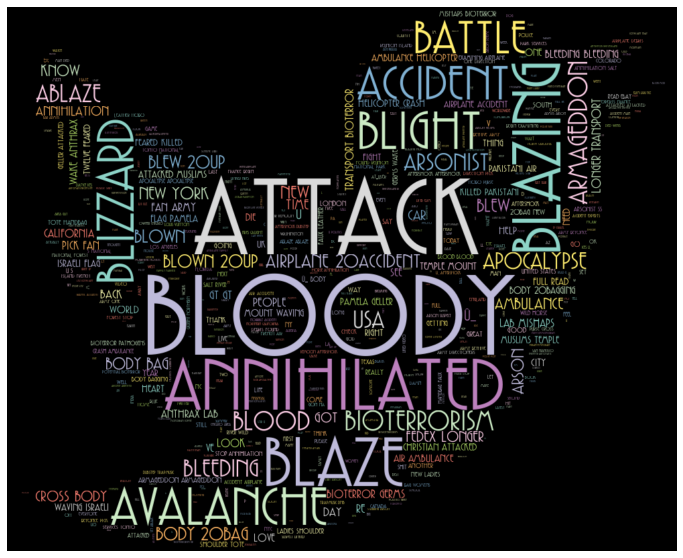

In [51]:
%%time
#Clean text and extract words
words, train_array = Process_df(full_text)

# Make wordcloud
make_cloud(words, TWITTER_LOGO, font_path=FONT_PATH)

In [47]:
def scores_list_to_df(scores):
    """
    Takes a list and turns it into a sorted dataframe through a dict
    in an intermediate step.
    
    Args:
        scores: List of scores with models attributed to them

    Returns:
        A dataframe sorted by accuracy with 2 different bagging shemes
    
    """
    score_dict= dict((key,d[key]) for d in scores for key in d)
    score_df = pd.DataFrame.from_dict(score_dict, orient='index', columns=['vec_accuracy', 'Tfid_accuracy'])
    
    return score_df.sort_values(by=['vec_accuracy', 'Tfid_accuracy'], ascending = False)

In [48]:
%%time
models = get_models()

converter = TfidfTransformer()
Tfid_train_array = converter.fit_transform(train_array).toarray()

pca = PCA(n_components = 10, svd_solver='full')
pca_train_array = pca.fit_transform(train_array)

scores = []
for model in models:
    clf = models[model]
    vec_score = np.mean(cross_val_score(clf,train_array, y, cv = 5))
    Tfid_score = np.mean(cross_val_score(clf, Tfid_train_array, y, cv = 5))
    pca_score = np.mean(cross_val_score(clf, pca_train_array, y, cv = ))
    
    print(model)
    print(f"Accuracy with vectorizer for {model} = {vec_score:.1%}")
    print(f"Accuracy with tifd converter for {model} = {Tfid_score:.1%}")
    print(f"Accuracy with pca for {model} = {pca_score:.1%}")
    print("\n"*2)
    
    score = {model:[vec_score, Tfid_score]}
    scores.append(score)

Gaussian NB
Accuracy with vecotrizer for Gaussian NB = 35.7%
Accuracy with converter for Gaussian NB = 37.7%
Accuracy with pca for Gaussian NB = 62.8%



Multinomial NB
Accuracy with vecotrizer for Multinomial NB = 38.9%
Accuracy with converter for Multinomial NB = 46.6%
Accuracy with pca for Multinomial NB = nan%





C:\Users\bless\Anaconda3\envs\PyCharm Scripts\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Negative values in data passed to MultinomialNB (input X)

  FitFailedWarning)
C:\Users\bless\Anaconda3\envs\PyCharm Scripts\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Negative values in data passed to MultinomialNB (input X)

  FitFailedWarning)
C:\Users\bless\Anaconda3\envs\PyCharm Scripts\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Negative values in data passed to MultinomialNB (input X)

  FitFailedWarning)
C:\Users\bles

SVC
Accuracy with vecotrizer for SVC = 39.4%
Accuracy with converter for SVC = 40.1%
Accuracy with pca for SVC = 63.8%



LR
Accuracy with vecotrizer for LR = 40.0%
Accuracy with converter for LR = 57.3%
Accuracy with pca for LR = 64.3%



RF
Accuracy with vecotrizer for RF = 40.1%
Accuracy with converter for RF = 37.8%
Accuracy with pca for RF = 51.4%



SVC calibrated
Accuracy with vecotrizer for SVC calibrated = 69.5%
Accuracy with converter for SVC calibrated = 70.4%
Accuracy with pca for SVC calibrated = 63.1%



LR calibrated
Accuracy with vecotrizer for LR calibrated = 71.5%
Accuracy with converter for LR calibrated = 71.1%
Accuracy with pca for LR calibrated = 69.6%



Wall time: 16.4 s


In [49]:
model_scores_df = scores_list_to_df(scores)
model_scores_df

,vec_accuracy,Tfid_accuracy
LR calibrated,0.715,0.711
SVC calibrated,0.695,0.704
RF,0.401,0.378
LR,0.400,0.573
SVC,0.394,0.401
Multinomial NB,0.389,0.466
Gaussian NB,0.357,0.377


In [50]:
model_scores_df.values.round(2)

array([[0.72, 0.71],
       [0.7 , 0.7 ],
       [0.4 , 0.38],
       [0.4 , 0.57],
       [0.39, 0.4 ],
       [0.39, 0.47],
       [0.36, 0.38]])

In [17]:
best_model = models[model_scores_df.index[1]]

In [18]:
filename = 'finalized_model.sav'
joblib.dump(best_model, filename)

['finalized_model.sav']

# Generate predictions

In [21]:
test = pd.read_csv(r".\Data\test.csv").set_index('id')

In [22]:
test_text = test.keyword.fillna(' ')+' '+test.location.fillna(' ') +' '+test.text.fillna(' ')

Wall time: 21.4 s


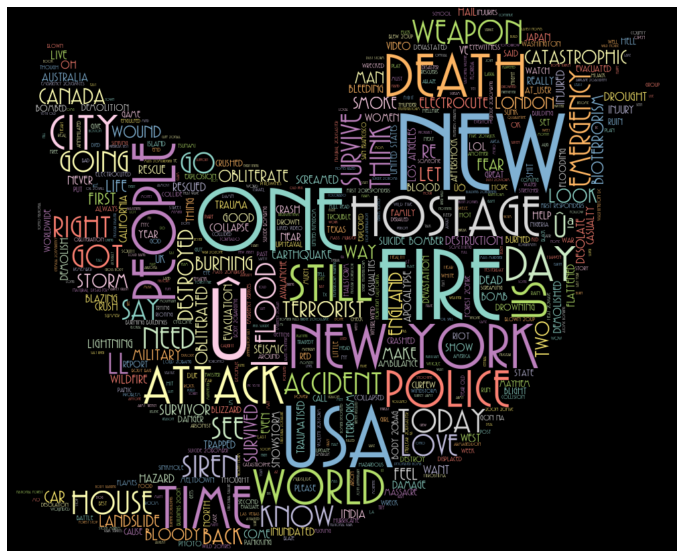

In [39]:
%%time
#Clean text and extract words
test_words, test_array = Process_df(test_text)

#Make wordcloud
make_cloud(test_words, TWITTER_LOGO)

In [24]:
import collections
c = collections.Counter(test_words)



In [25]:
c.most_common(90)

[('new', 200),
 ('like', 145),
 ('fire', 138),
 ('usa', 117),
 ('emergency', 111),
 ('suicide', 107),
 ('get', 106),
 ('news', 90),
 ('would', 86),
 ('body', 86),
 ('one', 83),
 ('people', 81),
 ('first', 78),
 ('attack', 77),
 ('disaster', 76),
 ('burning', 75),
 ('york', 71),
 ('buildings', 71),
 ('nuclear', 70),
 ('police', 68),
 ('california', 66),
 ('crash', 65),
 ('forest', 64),
 ('storm', 64),
 ('world', 63),
 ('mass', 63),
 ('video', 60),
 ('city', 58),
 ('dead', 58),
 ('us', 55),
 ('wild', 54),
 ('bomb', 54),
 ('fires', 53),
 ('got', 52),
 ('time', 52),
 ('still', 51),
 ('accident', 50),
 ('hiroshima', 50),
 ('watch', 50),
 ('bombing', 50),
 ('20fires', 50),
 ("'re", 49),
 ('today', 49),
 ('army', 49),
 ('full', 49),
 ('canada', 48),
 ('united', 47),
 ('two', 47),
 ('collapse', 47),
 ('going', 46),
 ('deluged', 46),
 ('demolished', 46),
 ('love', 45),
 ('last', 44),
 ('go', 44),
 ('know', 44),
 ('see', 44),
 ('australia', 44),
 ('life', 43),
 ('make', 43),
 ('wildfire', 43),
 

In [26]:
train_array.shape

(1000, 410)

In [27]:
test_array.shape

(3263, 1554)

In [28]:
# loaded_model = joblib.load(filename)
# result = loaded_model.score(train_array, Y_test)

# Legacy

In [29]:
def plot_calibration_curve(est, name, fig_index):
    
    print(__doc__)

# Author: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD Style.
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1.)

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

In [30]:
# def test_models(x_train, y_train, x_test, y_test):
#     #fitted_models = []
    
#     models = {'NB': GaussianNB(),
#               'SVC': LinearSVC(max_iter = 1000),
#               'LR': LogisticRegression(C = 0.6),
#               'RF': RandomForestClassifier(n_estimators = 200), 
#               'SVC calibrated':CalibratedClassifierCV((LinearSVC(max_iter = 10000)), cv = 2, method = 'sigmoid'),
#               'LR calibrated': CalibratedClassifierCV(LogisticRegression(), method = 'sigmoid',cv = 2)}
#     return models
# #     for name, model in models.items():
# #         classifier = model.fit(X_train, y_train)
# #         y_pred = classifier.predict(x_test)
# #         fitted_models.append(classifier)
# #         print(name)
# #         print('Accuracy score:', round(accpauracy_score(y_test, y_pred), 2))
# #         #print(confusion_matrix(y_test, y_pred))
# #         #print(classification_report(y_test, y_pred))
    
# #     return fitted_models